<a href="https://colab.research.google.com/github/nRknpy/MNIST-Pytorch-tutorial/blob/main/MNIST_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNISTデータセットを取得

In [ ]:
val_rate = 0.2

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
# 訓練，評価用
trainval_dataset = datasets.MNIST(
    "./data",
    train=True,
    transform=transform,
    download=True
)
# 訓練用と評価用に分ける
train_size = int(len(trainval_dataset)*(1-val_rate))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset,
                                                           [train_size, val_size])

# テスト用
test_dataset = datasets.MNIST(
    "./data",
    train=False,
    transform=transform,
    download=True
)

In [ ]:
def mnist_show(data):
  npimg = data[0].numpy().reshape((28, 28))
  plt.title(f"{data[1]}")
  plt.imshow(npimg, cmap="gray")
  plt.show()

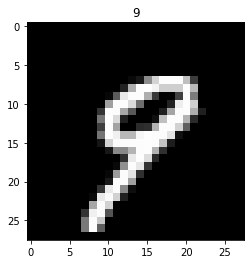

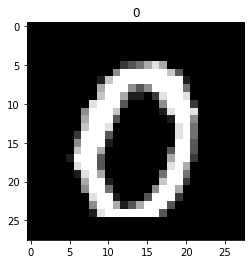

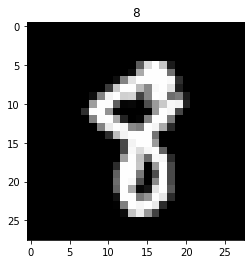

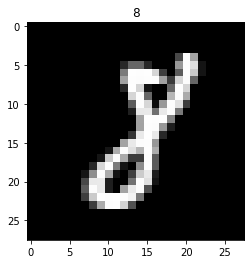

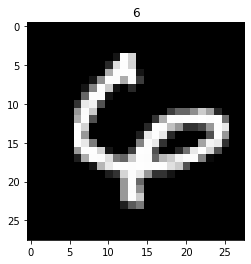

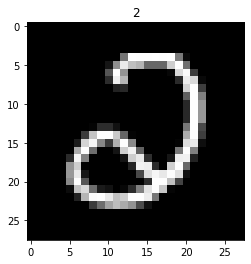

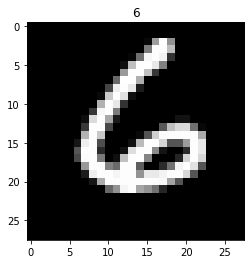

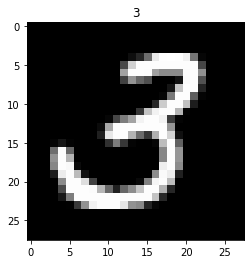

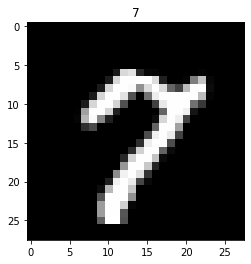

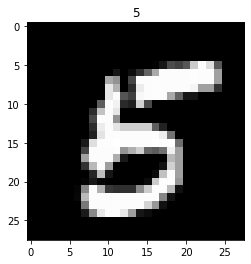

In [ ]:
# データセットの中身を見てみる
for i in range(10):
  mnist_show(train_dataset[i])
  pass

In [ ]:
num_batch = 128

In [ ]:
# DataLoaderを作成
train_dataloader = DataLoader(train_dataset,
                              batch_size=num_batch,
                              shuffle=True,
                              drop_last=True)
val_dataloader = DataLoader(val_dataset,
                            batch_size=num_batch,
                            shuffle=False)
test_dataloader = DataLoader(test_dataset,
                             shuffle=False)

# NNを設計

In [ ]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(28*28, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
  
  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    x = F.log_softmax(x, dim=1)
    return x

![architecture](https://drive.google.com/uc?id=17A0i86fTTMqZSBwXw-xf9XbjBN2mPq6-)

In [ ]:
model = NN().to(device)

# 損失関数と最適化手法を定義

In [ ]:
# 損失関数
criterion = nn.CrossEntropyLoss()
# 最適化手法
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 学習

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader):
  model.train()
  train_batch_loss = []
  for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    train_batch_loss.append(loss.item())
  
  model.eval()
  val_batch_loss = []
  with torch.no_grad():
    for x, y in val_dataloader:
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = criterion(output, y)
      val_batch_loss.append(loss.item())
  
  return model, np.mean(train_batch_loss), np.mean(val_batch_loss)

In [ ]:
# 訓練データを何周するか
num_epochs = 70

  1%|▏         | 1/70 [00:13<15:36, 13.58s/it]

Train loss: 0.4338677893280983, Validation loss: 0.21888794504264567


 16%|█▌        | 11/70 [01:15<06:00,  6.10s/it]

Train loss: 0.017989563509433842, Validation loss: 0.11395174173509424


 30%|███       | 21/70 [02:18<05:07,  6.28s/it]

Train loss: 0.005964594447170384, Validation loss: 0.13983682024867294


 44%|████▍     | 31/70 [03:19<03:53,  5.98s/it]

Train loss: 0.0011091128109898514, Validation loss: 0.1457514771875836


 59%|█████▊    | 41/70 [04:18<02:51,  5.93s/it]

Train loss: 0.005549585114373865, Validation loss: 0.1397436959346994


 73%|███████▎  | 51/70 [05:19<01:54,  6.03s/it]

Train loss: 0.003009030233276159, Validation loss: 0.14975693525914896


 87%|████████▋ | 61/70 [06:18<00:53,  5.91s/it]

Train loss: 0.002604285865506881, Validation loss: 0.1786229075688096


100%|██████████| 70/70 [07:11<00:00,  6.16s/it]


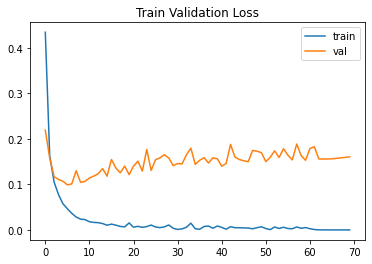

In [ ]:
train_loss = []
val_loss = []

for epoch in tqdm(range(num_epochs)):
  model, train_l, val_l = train_model(model, criterion, optimizer, train_dataloader, val_dataloader)
  train_loss.append(train_l)
  val_loss.append(val_l)
  if epoch % 10 == 0:
    print(f"Train loss: {train_loss[-1]}, Validation loss: {val_loss[-1]}")

plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.title("Train Validation Loss")
plt.legend()
plt.show()

# テスト

In [ ]:
def test_model(model, test_dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, label in test_dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            preds.append(output.argmax(1))
            labels.append(label)
    preds = torch.cat(preds, axis=0)
    labels = torch.cat(labels, axis=0)
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return preds, labels

In [ ]:
preds, trues = test_model(model, test_dataloader)
# 正解率
accuracy_score(trues, preds)

0.9828

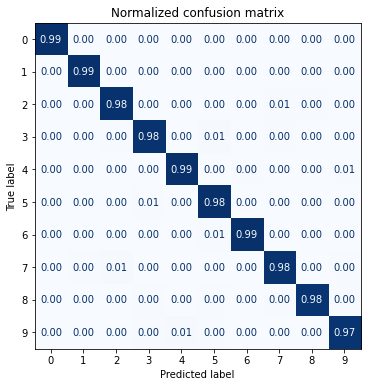

In [ ]:
# 混同行列
def plot_confusion_matrix(preds, trues, labels):
  cm = confusion_matrix(trues, preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(preds, trues, list(range(10)))